In [1]:
#  ЧАСТИНА 1: Імпорт бібліотек і завантаження даних
# Імпорт необхідних бібліотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from scipy.stats import zscore
import os

# Визначення середовища
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except:
    IN_COLAB = False
    print("Running locally")

# Завантаження датасету
dataset_filename = 'creditcard.csv'

if IN_COLAB:
    # В Colab - завантажуємо з Google Drive
    if not os.path.exists(dataset_filename):
        print("[+] Downloading dataset from Google Drive...")
        import gdown
        file_id = '1HAvXZNik1XaYZsY9znhVvuBQMIJ-Butm'
        url = f'https://drive.google.com/uc?export=download&id={file_id}'
        gdown.download(url, dataset_filename, quiet=False)
        print("[+] Download complete!")
    else:
        print("[!] Dataset already exists")
    
    dataset_path = dataset_filename
else:
    # Локально - файл має бути в папці
    dataset_path = dataset_filename
    if not os.path.exists(dataset_path):
        print("[!] Dataset not found locally!")
        print(" Please download from:")
        print("   https://drive.google.com/file/d/1HAvXZNik1XaYZsY9znhVvuBQMIJ-Butm/view")
        raise FileNotFoundError(f"Please download {dataset_filename} to this directory")

# Завантаження даних
# dataset_path = 'creditcard.csv'
df_raw = pd.read_csv(dataset_path)

Mounted at /content/drive


In [2]:
#  ЧАСТИНА 2: Вибір даних для мого варіанту
# Вибір рядків для вашого варіанту
df = df_raw.iloc[85440:113926].reset_index(drop=True)

# Перевірка структури даних
print("Форма вибірки:", df.shape)
print("Опис вибірки:")
print(df.describe())

# Вибір ознак для аналізу
features = [col for col in df.columns if col not in ['Time', 'Class']]
X = df[features]

# Додавання міток класів для аналізу
class_labels = df['Class']

Форма вибірки: (28486, 31)
Опис вибірки:
               Time            V1            V2            V3            V4  \
count  28486.000000  28486.000000  28486.000000  28486.000000  28486.000000   
mean   67090.478340     -0.229107      0.052544      0.685146      0.131732   
std     3591.028269      1.735127      1.537766      1.089050      1.260612   
min    60776.000000    -33.404082    -38.436817    -10.207116     -4.897347   
25%    63990.000000     -1.007814     -0.543346      0.154765     -0.651489   
50%    67233.000000     -0.267015      0.134290      0.733935      0.173149   
75%    70132.750000      1.161714      0.827539      1.342670      0.951559   
max    73262.000000      1.636615     12.785971      3.791503     12.699542   

                 V5            V6            V7            V8            V9  \
count  28486.000000  28486.000000  28486.000000  28486.000000  28486.000000   
mean      -0.301058      0.090693     -0.127191      0.071795     -0.203779   
std       

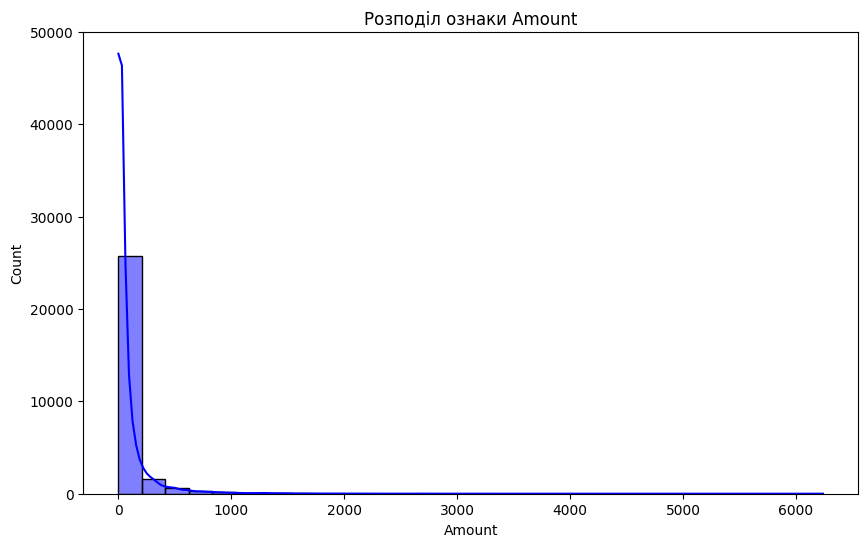

In [3]:
#  ЧАСТИНА 3: Попередній аналіз даних
# Візуалізація розподілу однієї з ознак
plt.figure(figsize=(10, 6))
sns.histplot(X['Amount'], bins=30, kde=True, color='blue')
plt.title('Розподіл ознаки Amount')
plt.show()

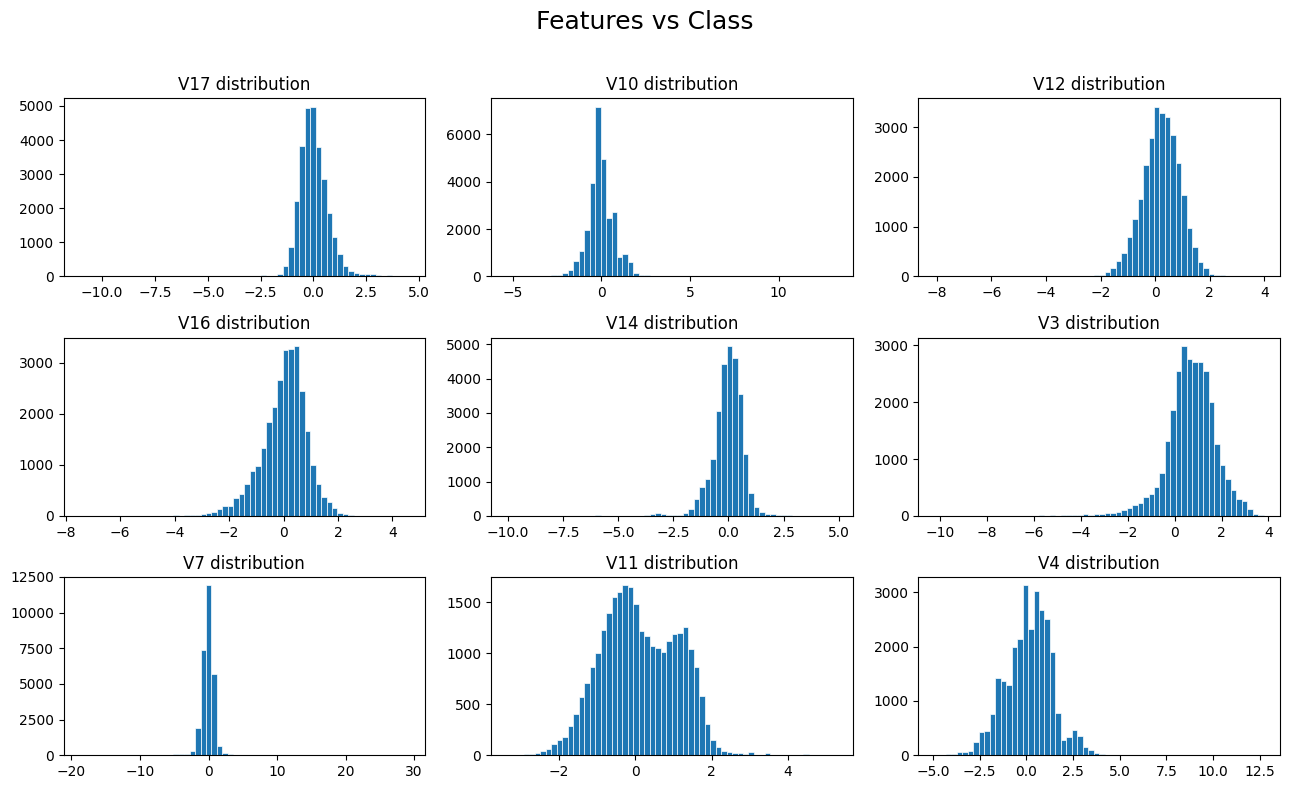

In [4]:
#візуалізація датасету df до того, як до нього
#будуть застосовані різні методи виявлення викидів
#і їх вилучення

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Features vs Class\n', size = 18)

axes[0,0].hist(df['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout()

Кількість викидів за методом IQR: 39404


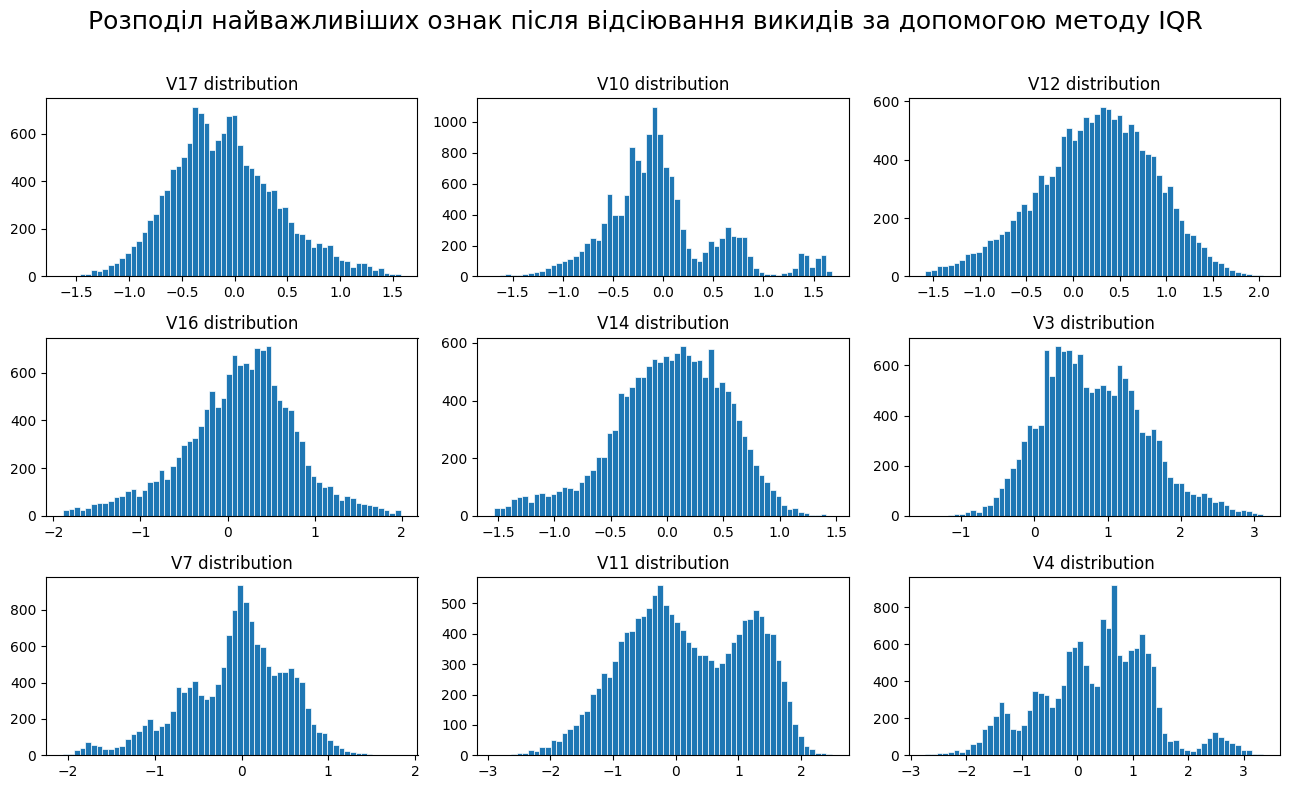

In [5]:
#  ЧАСТИНА 4: Виявлення викидів — метод IQR
# 1. Метод Tukey's IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25) # 1-й квартиль (відокремлюємо перші 25% даних від решти)
    Q3 = data.quantile(0.75) # 3-й квартиль (відокремлюємо перші 75% даних від решти)
    IQR = Q3 - Q1 #різниця між першими двома
    lower_bound = Q1 - 1.5 * IQR # Нижня межа для викидів
    upper_bound = Q3 + 1.5 * IQR # Верхня межа для викидів
    return (data < lower_bound) | (data > upper_bound)  #все, що виходить за ці межі - буде викидом (True)

iqr_outliers = detect_outliers_iqr(X)

df_out = df[~iqr_outliers.any(axis=1)].reset_index(drop=True) # з основного датасету відкидуємо викиди

print("Кількість викидів за методом IQR:", iqr_outliers.sum().sum())

#Візуалізація df_out - датасету після вилучення викидів

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Розподіл найважливіших ознак після відсіювання викидів за допомогою методу IQR\n', size = 18)

axes[0,0].hist(df_out['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df_out['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df_out['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df_out['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df_out['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df_out['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df_out['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df_out['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df_out['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout()

Кількість викидів за методом стандартного відхилення: 8653
The lower bound value is: -2.871398817179642
The upper bound value is: 3.090887192586831


NameError: name 'df_out3' is not defined

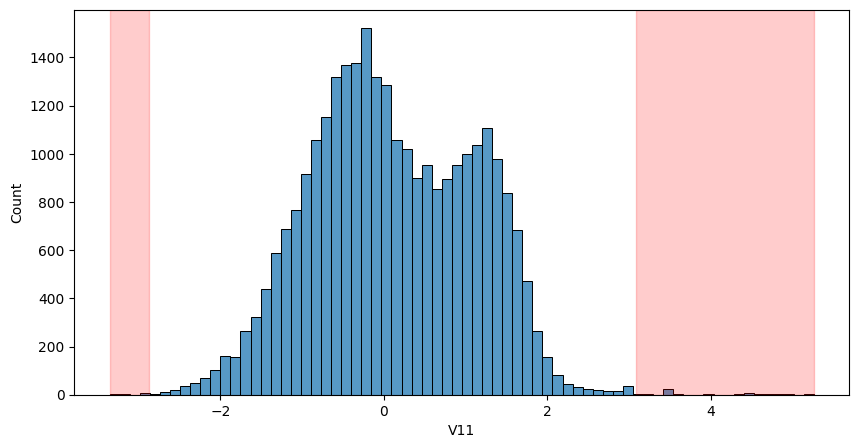

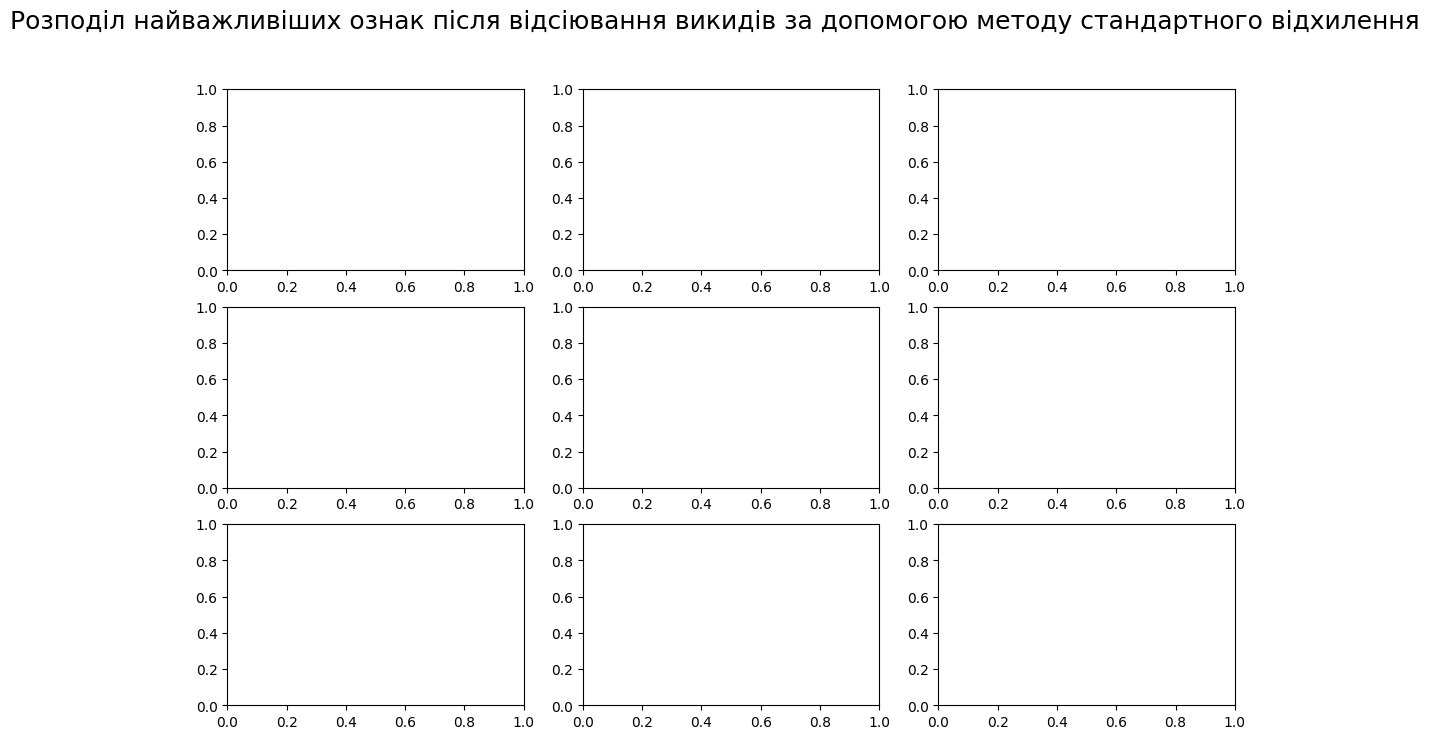

In [6]:
#  ЧАСТИНА 5: Виявлення викидів — метод стандартного відхилення
# 2. Метод стандартного відхилення
def detect_outliers_std(data, threshold=3):
    mean = data.mean() # Середнє значення
    std_dev = data.std()  # Стандартне відхилення
    lower_bound = mean - threshold * std_dev
    upper_bound = mean + threshold * std_dev
    return (data < lower_bound) | (data > upper_bound) #все, що виходить за ці межі - буде викидом (True)

std_outliers = detect_outliers_std(X)

df_out2 = df[~std_outliers.any(axis=1)].reset_index(drop=True) # з основного датасету відкидуємо викиди

print("Кількість викидів за методом стандартного відхилення:", std_outliers.sum().sum())

# Візуалізація датасету після вилучення викидів, знайдених методом стандартного відхилення
# (ТІЛЬКИ ОЗНАКА V11 !!)
data_mean, data_std = df['V11'].mean(), df['V11'].std()
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off

print('The lower bound value is:', data_mean - cut_off)
print('The upper bound value is:', data_mean + cut_off)

plt.figure(figsize = (10,5))
sns.histplot(x = 'V11', data=df, bins=70)
plt.axvspan(xmin = lower,xmax= df.V11.min(),alpha=0.2, color='red')
plt.axvspan(xmin = upper,xmax= df.V11.max(),alpha=0.2, color='red')

# Візуалізація датасету після вилучення викидів, знайдених методом стандартного відхилення
# (РЕШТА ОЗНАК)

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Розподіл найважливіших ознак після відсіювання викидів за допомогою методу стандартного відхилення\n', size = 18)

axes[0,0].hist(df_out2['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df_out2['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df_out2['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df_out2['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df_out2['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df_out2['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df_out2['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df_out2['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df_out2['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout()

In [ ]:
#  ЧАСТИНА 6: Виявлення викидів — метод Z-Score
# 3. Метод Z-Score
z_scores = zscore(X)
z_outliers = (np.abs(z_scores) > 3)
total_outliers = np.sum(z_outliers)
df_out3 = df[~z_outliers.any(axis=1)].reset_index(drop=True) # з основного датасету відкидуємо викиди

#Візуалізація df-out3 - датасет з вилученими викидами
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Розподіл найважливіших ознак після відсіювання викидів за допомогою методу z-score\n', size = 18)

axes[0,0].hist(df_out3['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df_out3['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df_out3['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df_out3['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df_out3['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df_out3['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df_out3['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df_out3['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df_out3['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout()

print("Кількість викидів за методом Z-Score:", total_outliers)

In [ ]:
# ЧАСТИНА 7: Виявлення викидів — Modified Z-Score
# 4. Modified Z-Score
def modified_zscore(data):
    median = np.median(data, axis=0)
    mad = np.median(np.abs(data - median), axis=0)
    return 0.6745 * (data - median) / mad

mod_z_scores = modified_zscore(X)
mod_z_outliers = (np.abs(mod_z_scores) > 3.5)
df_out4 = df[~mod_z_outliers.any(axis=1)].reset_index(drop=True) # з основного датасету відкидуємо викиди

total_outliers = np.sum(mod_z_outliers.values)
print("Кількість викидів за Modified Z-Score:", total_outliers)

#Візуалізація df-out4 - датасет з вилученими викидами
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,8))
fig.suptitle('Розподіл найважливіших ознак після відсіювання викидів за допомогою методу Modified Z-Score\n', size = 18)

axes[0,0].hist(df_out4['V17'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,0].axvline(np.median(df_out4['V17']), ls=':', c='g', label="Median")
axes[0,0].set_title("V17 distribution");

axes[0,1].hist(df_out4['V10'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,1].axvline(np.median(df_out4['V10']), ls=':', c='g', label="Median")
axes[0,1].set_title("V10 distribution");

axes[0,2].hist(df_out4['V12'], bins=60, linewidth=0.5, edgecolor="white")
axes[0,2].axvline(np.median(df_out4['V12']), ls=':', c='g', label="Median")
axes[0,2].set_title("V12 distribution");

axes[1,0].hist(df_out4['V16'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,0].set_title("V16 distribution");

axes[1,1].hist(df_out4['V14'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,1].set_title("V14 distribution");

axes[1,2].hist(df_out4['V3'], bins=60, linewidth=0.5, edgecolor="white")
axes[1,2].set_title("V3 distribution");

axes[2,0].hist(df_out4['V7'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,0].set_title("V7 distribution");

axes[2,1].hist(df_out4['V11'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,1].set_title("V11 distribution");

axes[2,2].hist(df_out4['V4'], bins=60, linewidth=0.5, edgecolor="white")
axes[2,2].set_title("V4 distribution");

plt.tight_layout()

In [ ]:
#  ЧАСТИНА 8: Виявлення викидів — Isolation Forest
# 5. Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest_labels = iso_forest.fit_predict(X) #навчання ізоляційного дерева на наборі даних X
iso_outliers = iso_forest_labels == -1 # якщо -1, то записуємо що це викид (масив значень true/false)
print("Кількість викидів за Isolation Forest:", np.sum(iso_outliers))

In [ ]:
# ======== ЧАСТИНА 9: Виявлення викидів — DBSCAN ========
# 6. DBSCAN
dbscan = DBSCAN(eps=3, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)
dbscan_outliers = dbscan_labels == -1
print("Кількість викидів за DBSCAN:", np.sum(dbscan_outliers))

In [ ]:
# ======== ЧАСТИНА 10: Порівняння результатів ========
print("\nПорівняння кількості викидів:")
print(f"IQR метод: {iqr_outliers.sum().sum()}")
print(f"Стандартне відхилення: {std_outliers.sum().sum()}")
print(f"Z-Score: {np.sum(z_outliers.values)}")
print(f"Modified Z-Score: {np.sum(mod_z_outliers.values)}")
print(f"Isolation Forest: {np.sum(iso_outliers)}")
print(f"DBSCAN: {np.sum(dbscan_outliers)}")